In [35]:


import numpy as np 
import pandas as pd 



In [37]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, normalize
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from IPython.display import display
import skimage.io
from skimage import io
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from IPython.display import display

In [43]:
im_width = 256
im_height = 256

train_files = []
mask_files = glob('masks*/*_segmentation*')

for i in mask_files:
    train_files.append(i.replace('_segmentation','').replace('masks', 'images').replace('.png','.jpg'))




In [44]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))
df.head()

image_path                            mask_path  mask
0  images\ISIC_0024306.jpg  masks\ISIC_0024306_segmentation.png     1
1  images\ISIC_0024307.jpg  masks\ISIC_0024307_segmentation.png     1
2  images\ISIC_0024308.jpg  masks\ISIC_0024308_segmentation.png     1
3  images\ISIC_0024309.jpg  masks\ISIC_0024309_segmentation.png     1
4  images\ISIC_0024310.jpg  masks\ISIC_0024310_segmentation.png     1

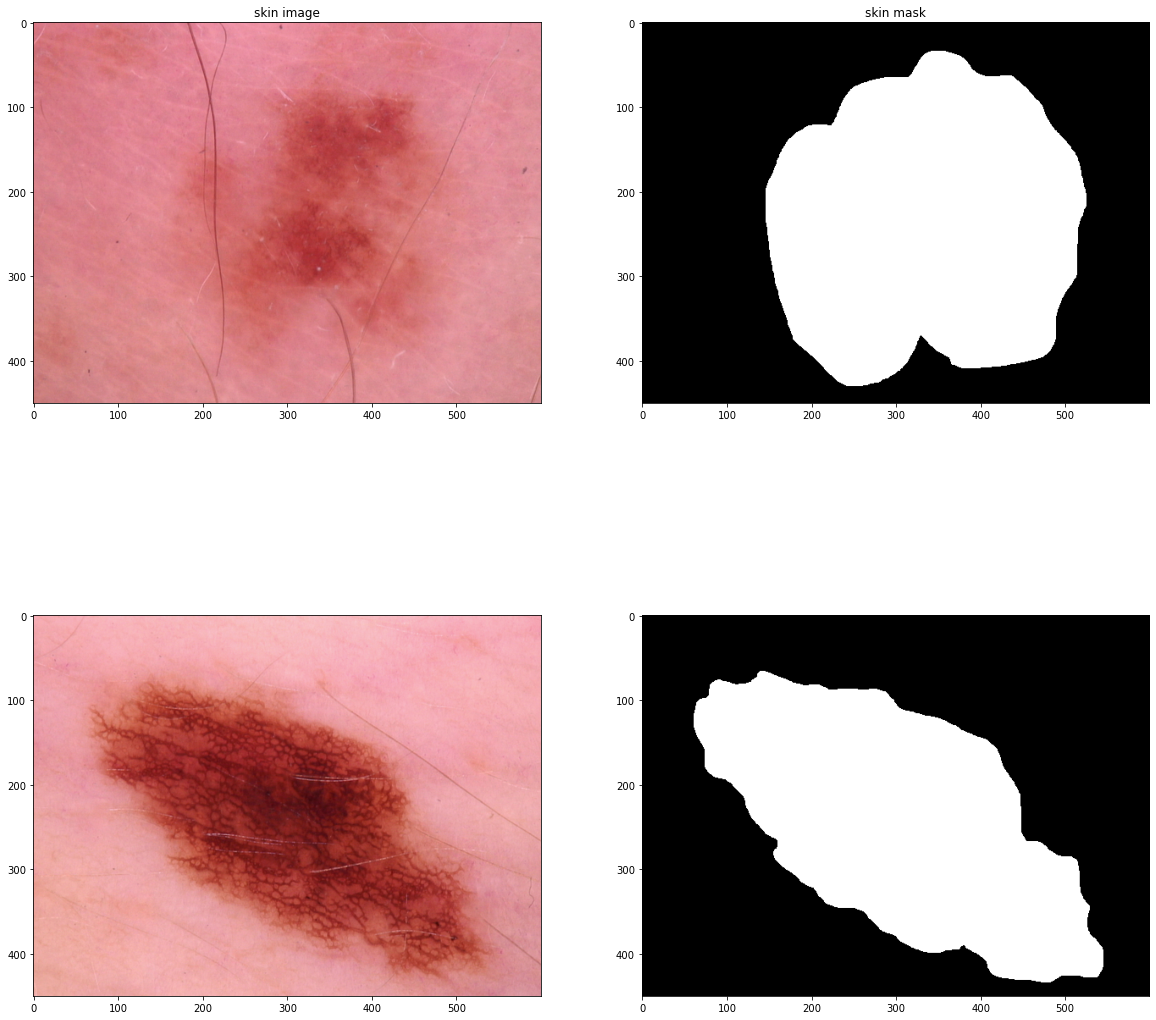

In [45]:

image1 = io.imread(df.image_path[1])

image2 = io.imread(df.image_path[2])

mask1 = io.imread(df.mask_path[1])
     
mask2 = io.imread(df.mask_path[2])


f, axarr = plt.subplots(2,2,figsize=(20, 20))
axarr[0,0].imshow(image1)
axarr[0,0].title.set_text("skin image")
axarr[0,1].imshow(mask1,cmap='gray')
axarr[0,1].title.set_text("skin mask")
matplotlib.rcParams.update({'font.size': 22})
axarr[1,0].imshow(image2)
axarr[1,1].imshow(mask2,cmap='gray')
 

In [46]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)


(7235, 3)
(1277, 3)
(1503, 3)


In [47]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [48]:
smooth=100

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [49]:
IMAGE_SIZE = (256, 256)

In [50]:
def BCDU_net_D3(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size)  
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
    

In [52]:
       
# def unet(input_size = (256,256,1)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     drop3 = Dropout(0.5)(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = Dropout(0.5)(conv4)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
#     merge6 = concatenate([drop3,up6], axis = 3)
#     conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = concatenate([conv2,up7], axis = 3)
#     conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv1,up8], axis = 3)
#     conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
#     conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
#     conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

#     model = Model(inputs,conv9)
    
#     model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

#     return model

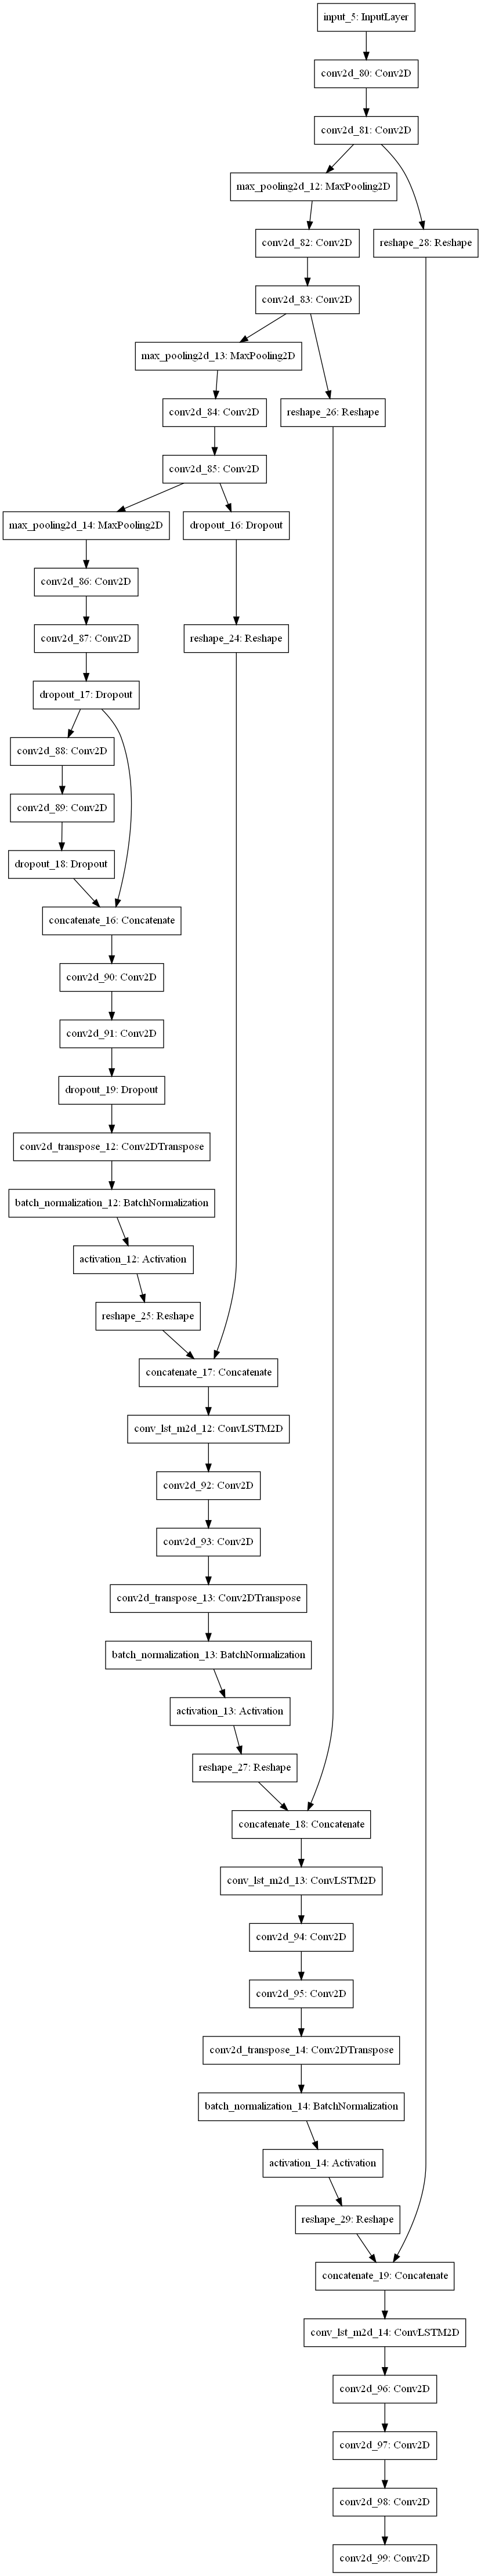

In [53]:
model = BCDU_net_D3((256,256,3))

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, 
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
  
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [16]:
EPOCHS =60
BATCH_SIZE = 15
learning_rate = 0.5e-3

In [17]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])

callbacks = [ModelCheckpoint('RESUNET1_skin_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 7235 validated image filenames.
Found 7235 validated image filenames.


2022-10-31 02:39:39.473596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-10-31 02:39:48.692337: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


483/482 [==============================] - ETA: 0s - loss: 0.7636 - iou: 0.3893 - dice_coef: 0.5581Found 1277 validated image filenames.
Found 1277 validated image filenames.
482/482 [==============================] - 517s 1s/step - loss: 0.7636 - iou: 0.3893 - dice_coef: 0.5581 - val_loss: 0.6615 - val_iou: 0.4441 - val_dice_coef: 0.6143
Epoch 2/60
482/482 [==============================] - 485s 1s/step - loss: 0.6249 - iou: 0.4662 - dice_coef: 0.6352 - val_loss: 0.6759 - val_iou: 0.4784 - val_dice_coef: 0.6461
Epoch 3/60
482/482 [==============================] - 486s 1s/step - loss: 0.5530 - iou: 0.5155 - dice_coef: 0.6795 - val_loss: 0.5837 - val_iou: 0.5363 - val_dice_coef: 0.6969
Epoch 4/60
482/482 [==============================] - 486s 1s/step - loss: 0.5029 - iou: 0.5541 - dice_coef: 0.7123 - val_loss: 0.4486 - val_iou: 0.5876 - val_dice_coef: 0.7395
Epoch 5/60
482/482 [==============================] - 486s 1s/step - loss: 0.4582 - iou: 0.5895 - dice_coef: 0.7409 - val_loss: 

Text(0.5, 1.0, 'Dice Coefficient')

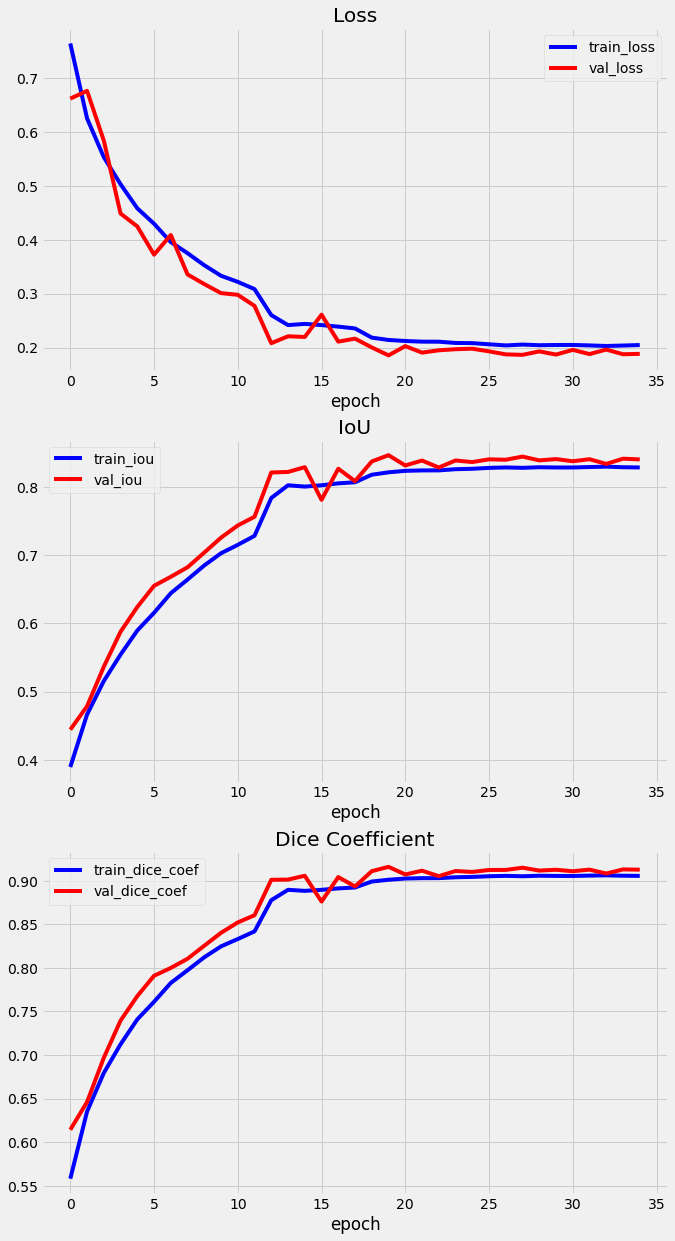

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('Dice Coefficient')

In [19]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 1503 validated image filenames.
Found 1503 validated image filenames.
100/100 [==============================] - 31s 313ms/step - loss: 0.2140 - iou: 0.8309 - dice_coef: 0.9067
Test loss:  0.21398185193538666
Test IOU:  0.8309048414230347
Test Dice Coefficent:  0.9066594243049622


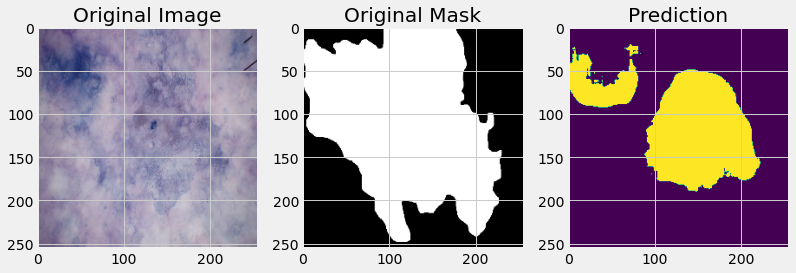

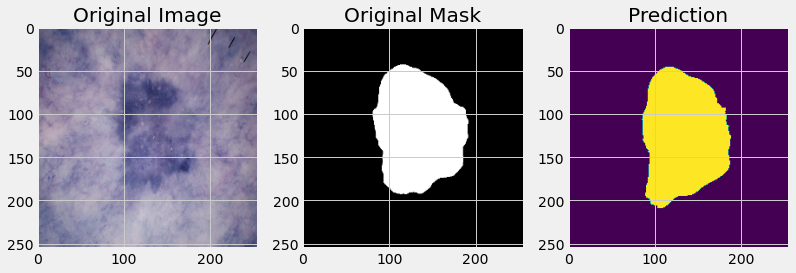

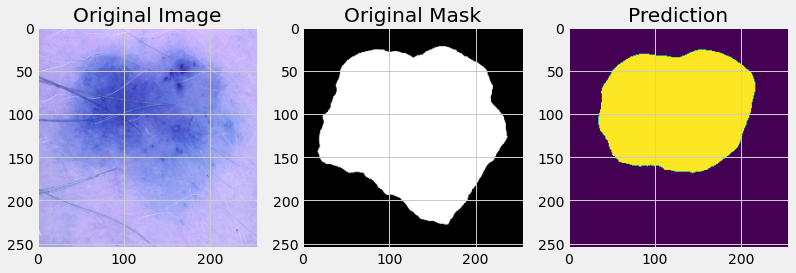

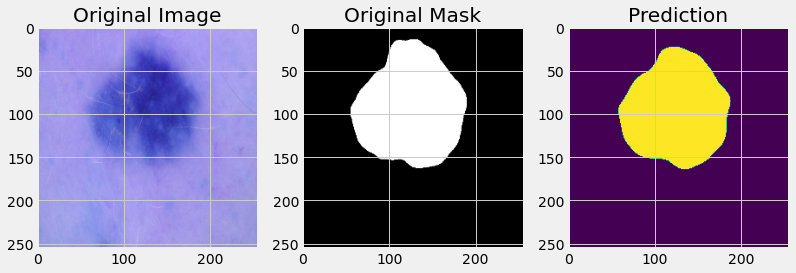

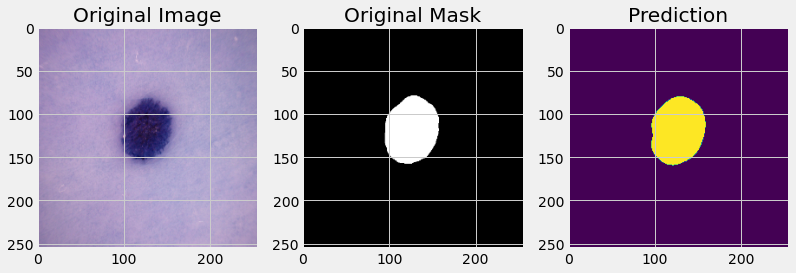

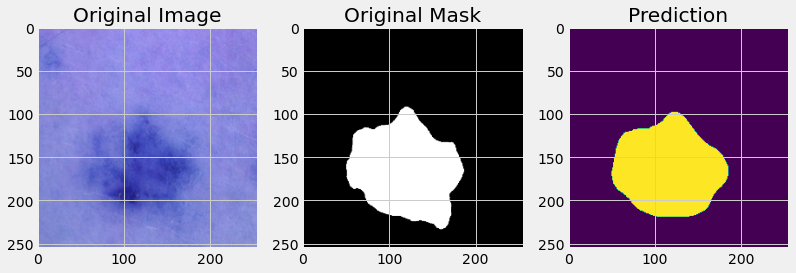

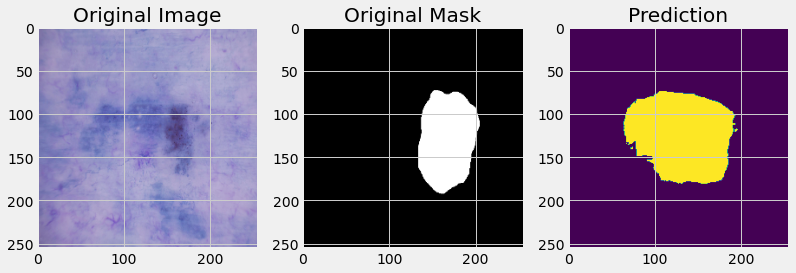

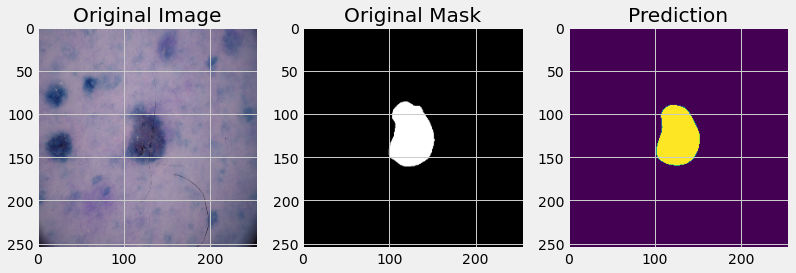

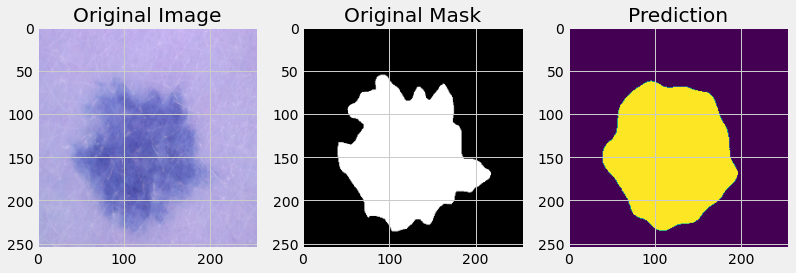

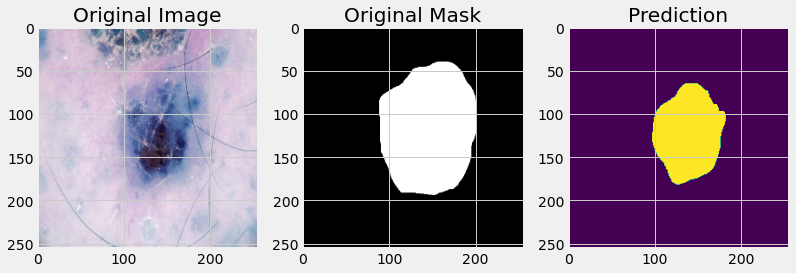

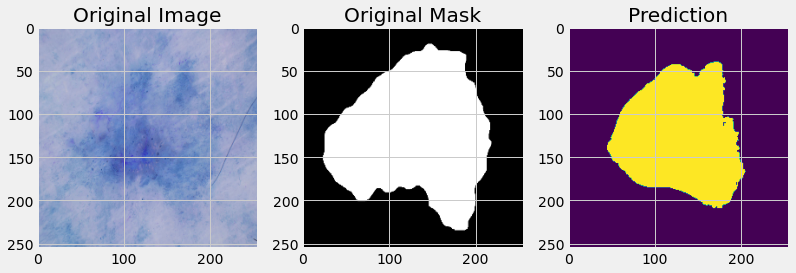

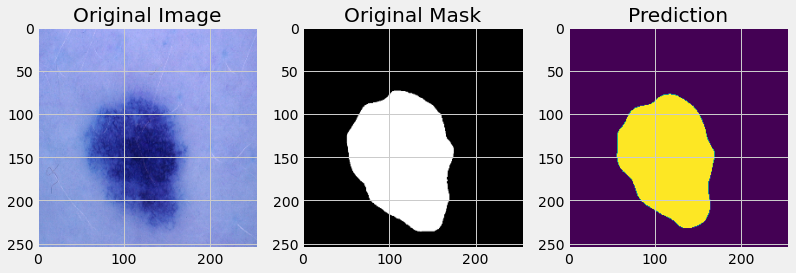

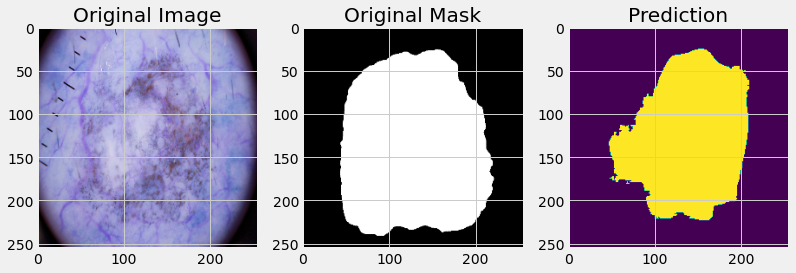

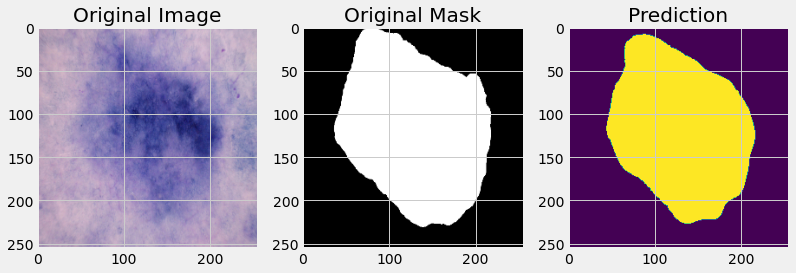

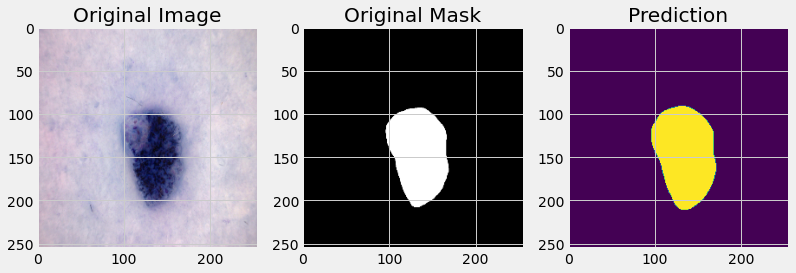

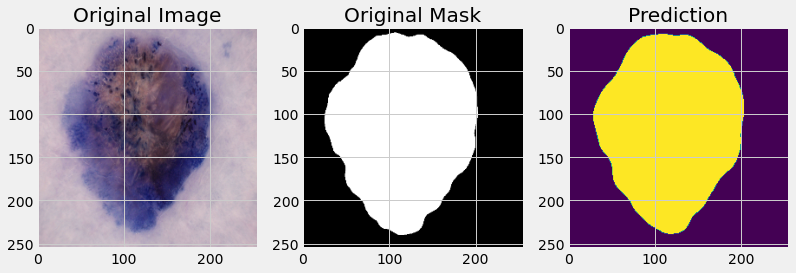

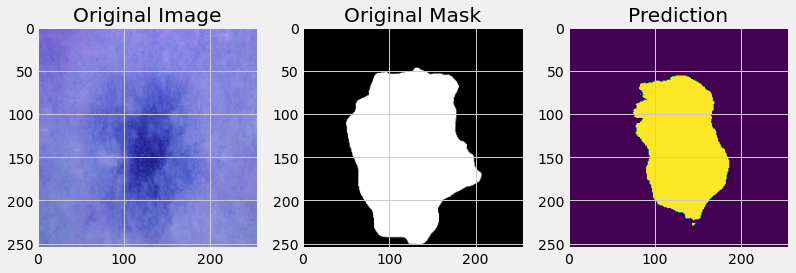

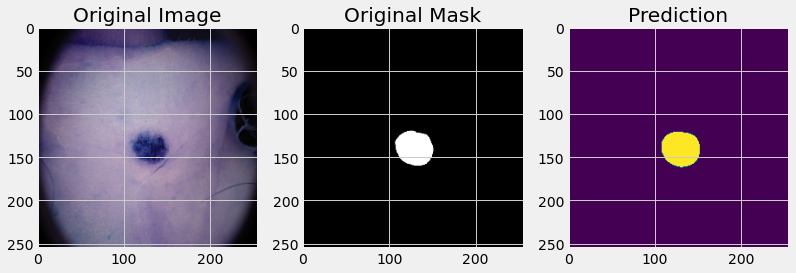

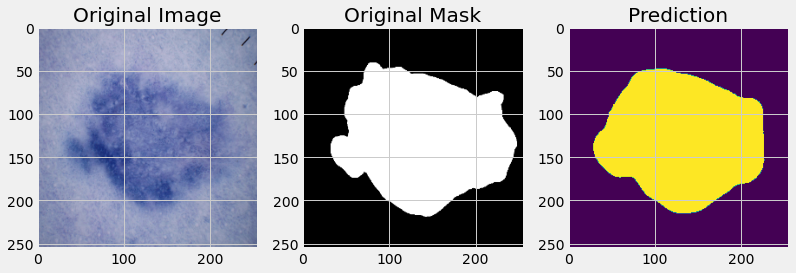

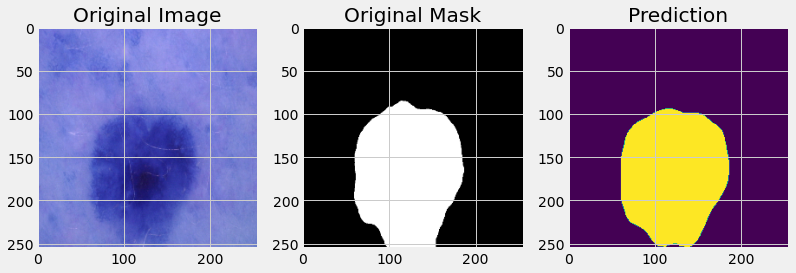

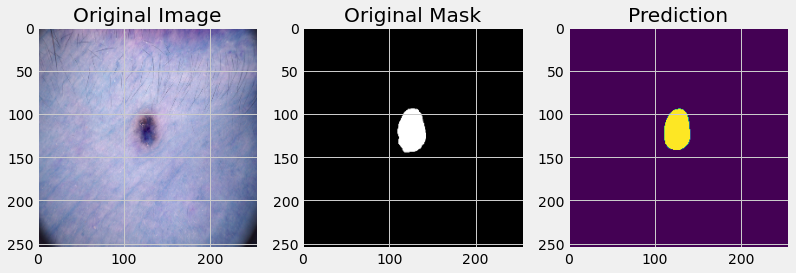

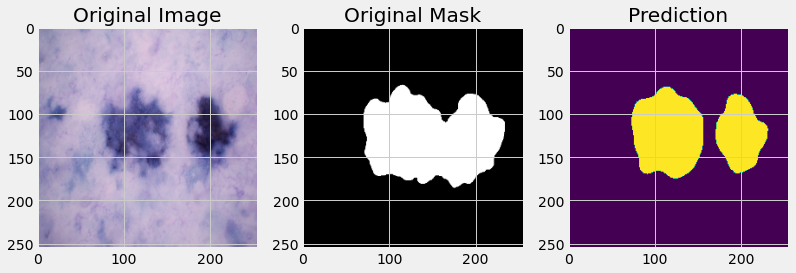

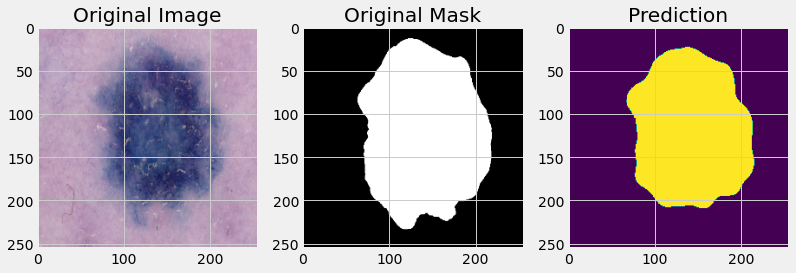

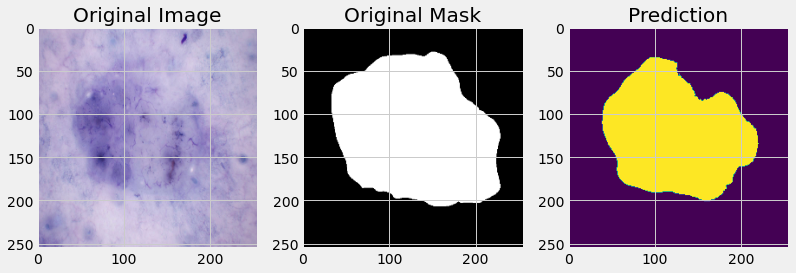

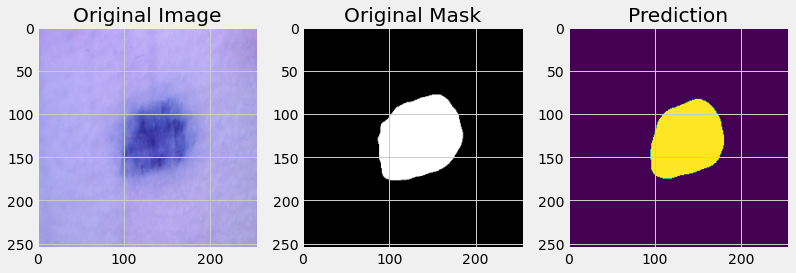

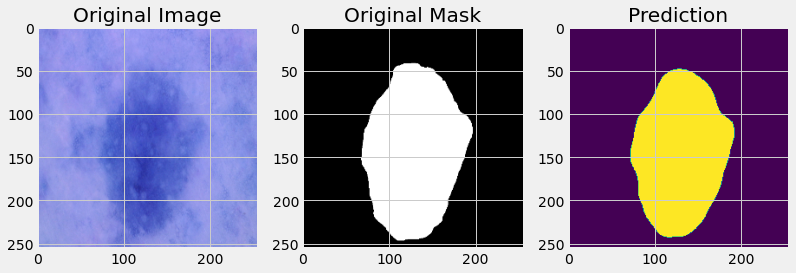

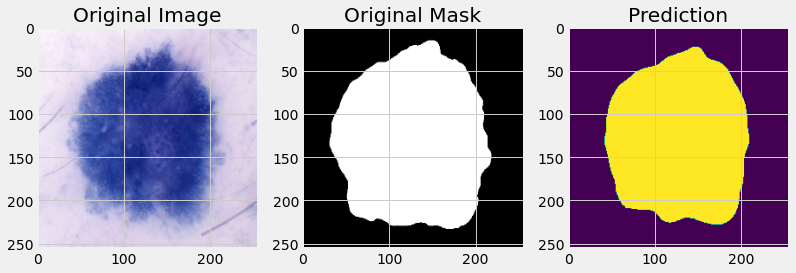

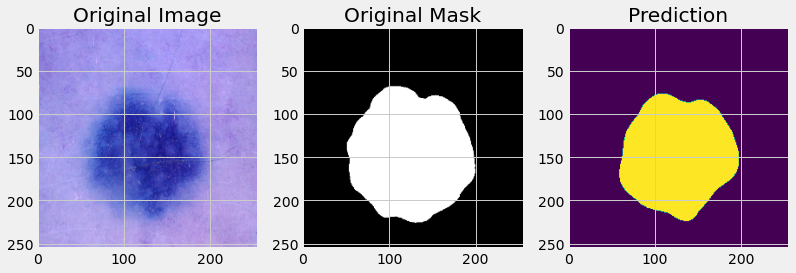

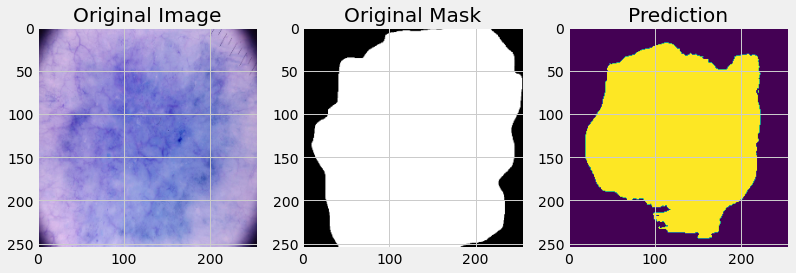

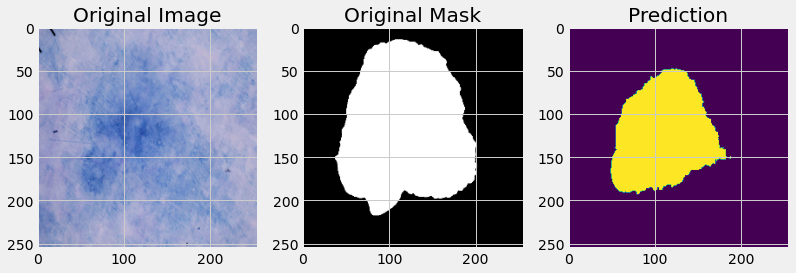

In [20]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    mask_img = cv2.imread(df_test['mask_path'].iloc[index])
    mask_img = cv2.resize(mask_img ,IMAGE_SIZE)
    mask_img = mask_img / 255
    mask_img = mask_img[np.newaxis, :, :, :]

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(mask_img))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [21]:
Result_df = pd.DataFrame(history.history)
Result_df.head()

loss       iou  dice_coef  val_loss   val_iou  val_dice_coef      lr
0  0.763603  0.389263   0.558127  0.661469  0.444054       0.614310  0.0005
1  0.624907  0.466225   0.635165  0.675861  0.478378       0.646105  0.0005
2  0.553020  0.515461   0.679461  0.583733  0.536344       0.696853  0.0005
3  0.502865  0.554138   0.712321  0.448581  0.587629       0.739522  0.0005
4  0.458234  0.589464   0.740919  0.424657  0.623995       0.767642  0.0005

In [22]:
Result_df.describe()

loss        iou  dice_coef   val_loss    val_iou  val_dice_coef  \
count  35.000000  35.000000  35.000000  35.000000  35.000000      35.000000   
mean    0.297514   0.746338   0.848003   0.277662   0.764295       0.860540   
std     0.138368   0.119974   0.088740   0.135645   0.112698       0.080807   
min     0.203098   0.389263   0.558127   0.185727   0.444054       0.614310   
25%     0.205957   0.693849   0.818438   0.193137   0.714735       0.832837   
50%     0.235605   0.806853   0.892217   0.208298   0.828490       0.905231   
75%     0.342971   0.827990   0.905121   0.309450   0.838881       0.911554   
max     0.763603   0.829748   0.906189   0.675861   0.846606       0.915925   

                 lr  
count  3.500000e+01  
mean   2.679286e-04  
std    2.428463e-04  
min    5.000001e-07  
25%    5.000000e-06  
50%    5.000000e-04  
75%    5.000000e-04  
max    5.000000e-04